We will use the [Variational Autoencoder](https://arxiv.org/abs/1312.6114), but slightly modified to suit our needs.

Note: you will find a lot of functions `fn()`. These functions are just meant to test if the code written is working as it should. I put the testing code inside these functions as I didn't want to waste the namespace.

In [27]:
!pip install torchinfo

In [28]:
# %load_ext autoreload
# %autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import torchinfo
from torchinfo import summary

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import pytz
from datetime import datetime
import time
# import glob
# import joblib
# import albumentations

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
# import seaborn as sns
# plt.style.use("fivethirtyeight")
# plt.style.use("default")

# import warnings
# warnings.filterwarnings("ignore")

%matplotlib inline
# %config InlineBackend.figure_format="svg"

print("Imports done!")

Imports done!


In [29]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

## Load and Preprocess the data

In [30]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [31]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [32]:
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5,
                                                    shuffle=True, stratify=y_test,
                                                    random_state=42)

In [33]:
print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape,
      y_valid.shape, y_test.shape, sep='\n')

(60000, 32, 32, 1)
(5000, 32, 32, 1)
(5000, 32, 32, 1)
(60000,)
(5000,)
(5000,)


In [34]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

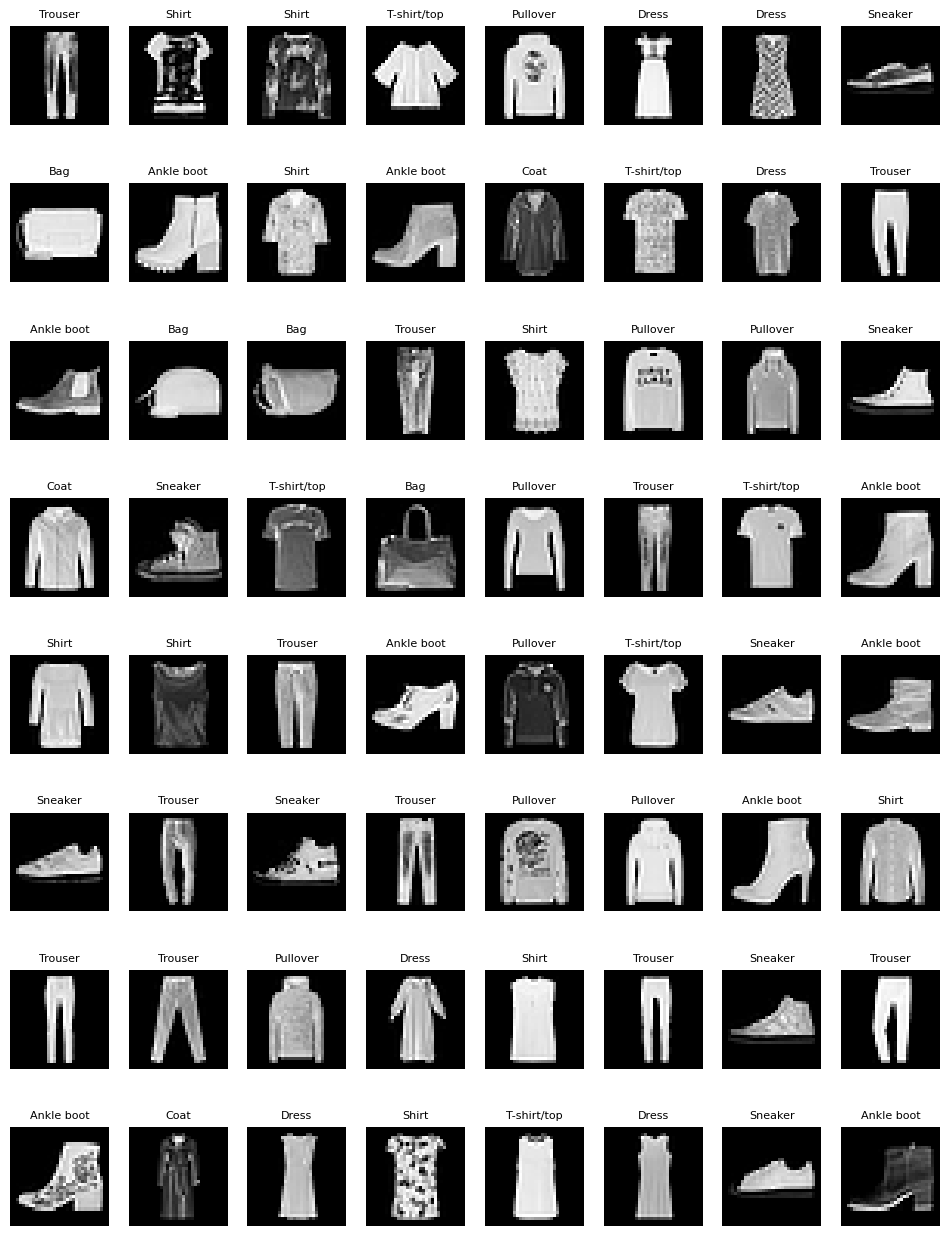

In [35]:
np.random.seed(42)

def visualize_data():
    nrows = 8
    ncols = 8
    indices = np.random.randint(low=0, high=60000, size=nrows*ncols).reshape(nrows,ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(12,16))
    for i in range(nrows):
        for j in range(ncols):
            idx = indices[i][j]
            img = x_train[idx]
            label = class_labels[y_train[idx]]
            ax[i,j].imshow(img, cmap="gray")
            ax[i,j].set_title(label, fontsize=8)
            ax[i,j].axis("off")


visualize_data()

## PyTorch Model

In [36]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [37]:
class CustomDataset(Dataset):
    def __init__(self, features, targets, augmentations=None):
        self.features = features
        self.targets = targets
        self.augmentations = augmentations

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx, :]
        image = torch.tensor(image, dtype=torch.float32)
        label = self.targets[idx]
        label = torch.tensor(label, dtype=torch.long)
        if self.augmentations is not None:
            image = self.augmentations(image)
        return image, label


In [38]:
train_dataset = CustomDataset(features=x_train.reshape(60000, 1, 32, 32), targets=y_train)
valid_dataset = CustomDataset(features=x_valid.reshape(5000, 1, 32, 32), targets=y_valid)
test_dataset = CustomDataset(features=x_test.reshape(5000, 1, 32, 32), targets=y_test)

In [39]:
"""Helpful utility functions for generative deep models."""

def set_dataloaders(batch_size=64):
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
                              # drop_last=True  # this will drop the last batch if its size is not 32
                              # pin_memory=True,
                              # num_workers=os.cpu_count())
    val_loader = DataLoader(valid_dataset,
                            batch_size=batch_size,
                            shuffle=False)
                            # drop_last=True  # this will drop the last batch if its size is not 32
                            # pin_memory=True,
                            # num_workers=os.cpu_count())
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
                             # drop_last=True  # this will drop the last batch if its size is not 32
                             # pin_memory=True,
                             # num_workers=os.cpu_count())
    return train_loader, val_loader, test_loader


def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # if version of pytorch is =< 1.7, then use torch.set_deterministic(True)
        # else use torch.use_deterministic_algorithms(True)
        torch.use_deterministic_algorithms(True)


def train_step_vae_v1(model, loss_fn, optimizer, dataloader, device,
                      reconstruction_weight=1):
    """
    Processes just one training step, ie, just one epoch.
    To be used inside the main the training function.
    """
    # initialize the total training loss value of this entire batch to 0
    total_train_loss = 0
    # initialize the total kl divergence of this entire batch to 0
    total_kl_div = 0
    # initialize the total reconstruction loss of this entire batch to 0
    total_recon_loss = 0
    # put the model in training mode
    model.train()
    # loop through the data loader batches
    for X, _ in dataloader:
        # we don't need y, as the model is tested on how accurately it can
        # reproduce the original image
        # send X the to device being used
        # we assume that the model is on this device already
        X = X.to(device)
        # forward pass
        encoded, z_mean, z_log_var, decoded = model(X)
        # encoded is the latent space embedding
        # z_mean and z_log_var are the sampling we do from a vae
        # decoded is the reconstructed image
        # ----------------------------------------------------------------
        # calculate the loss and add it to the batch's training loss
        # we now have 2 losses: reconstruction loss and kl divergence
        # 1. kl divergence
        # we sum over the latent space for the kl divergence term
        kl_div = (-0.5)*torch.sum(1 + z_log_var - z_mean**2
                                  - torch.exp(z_log_var), axis=1)
        batch_size = kl_div.size(0)
        kl_div = kl_div.mean()  # average over batch dimension
        total_kl_div += kl_div
        # 2. reconstruction loss
        reconstruction_loss = loss_fn(decoded, X)
        # sum over the pixels for the reconstruction loss
        # pixelwise = reconstruction_loss.view(batch_size, -1).sum(axis=1)
        # pixelwise = pixelwise.mean()  # average over batch dimension
        # total_recon_loss += pixelwise
        total_recon_loss += reconstruction_loss
        # total loss
        # the reconstruction_weight is a hyperparameter that tells how much should the
        # total loss focus on reconstruction loss and how much on the kl divergence
        # loss = reconstruction_weight*pixelwise + kl_div
        loss = reconstruction_weight*reconstruction_loss + kl_div
        total_train_loss += loss
        # ----------------------------------------------------------------
        # zero the gradients of the optimizer so that they don't accumulate
        optimizer.zero_grad()
        # do a backward pass on the loss
        loss.backward()
        # update the optimizer (ie, update the gradients)
        optimizer.step()
    # calculate the average training loss for this batch
    total_train_loss /= len(dataloader)
    total_kl_div /= len(dataloader)
    total_recon_loss /= len(dataloader)
    return total_train_loss, total_kl_div, total_recon_loss


def valid_step_vae_v1(model, loss_fn, dataloader, device,
                      reconstruction_weight=1):
    """
    Processes just one validation step, ie, just one epoch.
    To be used inside the main the training function.
    """
    # initialize the total validation loss value of this entire batch to 0
    total_valid_loss = 0
    # initialize the total kl divergence of this entire batch to 0
    total_kl_div = 0
    # initialize the total reconstruction loss of this entire batch to 0
    total_recon_loss = 0
    # put the model in training mode
    model.eval()
    # turn on the inference context manager
    with torch.inference_mode():
        # loop through the data loader batches
        for X, _ in dataloader:
            # we don't need y, as the model is tested on how accurately it can
            # reproduce the original image
            # send X the to device being used
            # we assume that the model is on this device already
            X = X.to(device)
            # forward pass
            encoded, z_mean, z_log_var, decoded = model(X)
            # encoded is the latent space embedding
            # z_mean and z_log_var are the sampling we do from a vae
            # decoded is the reconstructed image
            # ----------------------------------------------------------------
            # calculate the loss and add it to the batch's training loss
            # we now have 2 losses: reconstruction loss and kl divergence
            # 1. kl divergence
            # we sum over the latent space for the kl divergence term
            kl_div = (-0.5)*torch.sum(1 + z_log_var - z_mean**2
                                      - torch.exp(z_log_var), axis=1)
            batch_size = kl_div.size(0)
            kl_div = kl_div.mean()  # average over batch dimension
            total_kl_div += kl_div
            # 2. reconstruction loss
            reconstruction_loss = loss_fn(decoded, X)
            # sum over the pixels for the reconstruction loss
            # pixelwise = reconstruction_loss.view(batch_size, -1).sum(axis=1)
            # pixelwise = pixelwise.mean()  # average over batch dimension
            # total_recon_loss += pixelwise
            total_recon_loss += reconstruction_loss
            # total loss
            # the reconstruction_weight is a hyperparameter that tells how much should the
            # total loss focus on reconstruction loss and how much on the kl divergence
            # loss = reconstruction_weight*pixelwise + kl_div
            loss = reconstruction_weight*reconstruction_loss + kl_div
            total_valid_loss += loss
    # calculate the average validation loss for this batch
    # if you do total_valid_loss /= len(dataloader), then it gives inplace operation error
    # so better to write total_valid_loss = total_valid_loss/len(dataloader)
    total_valid_loss = total_valid_loss/len(dataloader)
    total_kl_div = total_kl_div/len(dataloader)
    total_recon_loss = total_recon_loss/len(dataloader)
    return total_valid_loss, total_kl_div, total_recon_loss


def set_scheduler(scheduler, results, scheduler_on="val_total_loss"):
    """Makes the neccessary updates to the scheduler."""
    if scheduler_on == "val_total_loss":
        scheduler.step(results["val_total_loss"][-1])
    elif scheduler_on == "val_kl_div":
        scheduler.step(results["val_kl_div"][-1])
    elif scheduler_on == "val_reconstruction_loss":
        scheduler.step(results["val_reconstruction_loss"][-1])
    elif scheduler_on == "train_total_loss":
        scheduler.step(results["train_total_loss"][-1])
    elif scheduler_on == "train_kl_div":
        scheduler.step(results["train_kl_div"][-1])
    elif scheduler_on == "train_reconstruction_loss":
        scheduler.step(results["train_reconstruction_loss"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def training_fn_v1(model, train_loader, val_loader, loss_fn, optimizer,
                    epochs, device, scheduler=None, scheduler_on="val_total_loss"):
    """
    A variation of the main training_fn function for generative deep learning models.
    """
    # create a results dictionary
    results = {
        "train_total_loss": [],
        "train_kl_div": [],
        "train_reconstruction_loss": [],
        "val_total_loss": [],
        "val_kl_div": [],
        "val_reconstruction_loss": []
    }
    # loop through the training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # call the training function
        train_loss, train_kl_div, train_recon_loss = train_step_vae_v1(model=model, loss_fn=loss_fn,
                                                                       optimizer=optimizer,
                                                                       dataloader=train_loader,
                                                                       device=device)
        # call the validation function
        val_loss, val_kl_div, val_recon_loss = valid_step_vae_v1(model=model, loss_fn=loss_fn,
                                                                 dataloader=val_loader,
                                                                 device=device)
        # update the results dictionary
        results["train_total_loss"].append(train_loss)
        results["train_kl_div"].append(train_kl_div)
        results["train_reconstruction_loss"].append(train_recon_loss)
        results["val_total_loss"].append(val_loss)
        results["val_kl_div"].append(val_kl_div)
        results["val_reconstruction_loss"].append(val_recon_loss)
        if scheduler is not None:
            # adjust the learning rate
            scheduler = set_scheduler(scheduler, results, scheduler_on)
        # print out what's happening
        print(
            f"Epoch: {epoch+1} | Train_total_loss: {train_loss:.5f} | "
            f"Train_kl_div: {train_kl_div:.5f} | Train_reconstruction_loss: {train_recon_loss:.5f} | "
            f"Val_loss: {val_loss:.5f} | Val_kl_div: {val_kl_div:.5f} | "
            f"Val_reconstruction_loss: {val_recon_loss:.5f}"
        )
    return results


def save_model_info(PATH, device, model, model_name, optimizer, optimizer_name,
                    scheduler=None, scheduler_name=""):
    model.to(device)
    torch.save(model.state_dict(), PATH/model_name)
    torch.save(optimizer.state_dict(), PATH/optimizer_name)
    if scheduler is not None:
        torch.save(scheduler.state_dict(), PATH/scheduler_name)
    print("Model info saved!")


def load_model_info(PATH, device, model, model_name, optimizer, optimizer_name,
                    scheduler=None, scheduler_name=""):
    model.load_state_dict(torch.load(PATH/model_name))
    model.to(device)
    optimizer.load_state_dict(torch.load(PATH/optimizer_name))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(PATH/scheduler_name))
    print("Model info loaded!")


def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


def visualize_results_vae(results):
    """Plot the training and validation total loss, kl divergence, and reconstruction loss
       given the results dictionary"""
    train_loss = results["train_total_loss"]
    train_kl_div = results["train_kl_div"]
    train_recon_loss = results["train_reconstruction_loss"]
    val_loss = results["val_total_loss"]
    val_kl_div = results["val_kl_div"]
    val_recon_loss = results["val_reconstruction_loss"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,14))
    if type(train_loss[0]) == torch.Tensor:
        if train_loss[0].get_device() != -1:  # this means tensor is on some gpu
            for i in range(len(train_loss)):
                train_loss[i] = train_loss[i].cpu().detach().numpy()
                train_kl_div[i] = train_kl_div[i].cpu().detach().numpy()
                train_recon_loss[i] = train_recon_loss[i].cpu().detach().numpy()
                val_loss[i] = val_loss[i].cpu().detach().numpy()
                val_kl_div[i] = val_kl_div[i].cpu().detach().numpy()
                val_recon_loss[i] = val_recon_loss[i].cpu().detach().numpy()
        elif train_loss[0].get_device() == -1:   # -1 means tensor is on a cpu
            for i in range(len(train_loss)):
                train_loss[i] = train_loss[i].detach().numpy()
                train_kl_div[i] = train_kl_div[i].detach().numpy()
                train_recon_loss[i] = train_recon_loss[i].detach().numpy()
                val_loss[i] = val_loss[i].detach().numpy()
                val_kl_div[i] = val_kl_div[i].detach().numpy()
                val_recon_loss[i] = val_recon_loss[i].detach().numpy()
    assert type(train_loss[0]) == np.ndarray, "elements of train_loss are not numpy arrays"
    # ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Total Loss")
    ax[0].plot(x, train_loss, label="train", color="orange")
    ax[0].plot(x, val_loss, label="val", color="blue")
    ax[0].legend()
    # ax[1].set_title("KL Divergence")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("KL Divergence")
    ax[1].plot(x, train_kl_div, label="train", color="orange")
    ax[1].plot(x, val_kl_div, label="val", color="blue")
    ax[1].legend()
    # ax[2].set_title("Reconstruction loss")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("Reconstruction loss")
    ax[2].plot(x, train_recon_loss, label="train", color="orange")
    ax[2].plot(x, val_recon_loss, label="val", color="blue")
    ax[2].legend()
    plt.show()



In [40]:
train_loader, val_loader, test_loader = set_dataloaders(128)

In [41]:
def fn():
    for X, y in train_loader:
        print(X.shape, y.shape)
        break
    pass

fn()

torch.Size([128, 1, 32, 32]) torch.Size([128])


**Key equations used in the Variational Autoencoder**

1. Sampling from a VAE
    - $$z = \mu + \sigma \cdot \epsilon$$
        - where $\epsilon$ is taken from standard multivariate normal distribution, ie, each component of $\epsilon$ is taken from $\mathcal{N(0,1)}$, which is the normal distribution with mean=0 and standard deviation=1.

2. Log-Var trick
    - We apply this trick to the above sampling
    - $$z = \mu + e^{\frac{1}{2} \text{log}(\sigma^2)} \cdot \epsilon$$

3. VAE Loss Function (ELBO - Evidence Lower Bound)
    - ELBO consists of 2 terms, both of which we need to minimize:
        1. Reconstruction term (squared error loss)
            - $$ \mathcal{L_1} = \Vert \mathbf{x} - \text{Dec}(\text{Enc}(\mathbf{x})) \Vert_2^2 = \sum_{\text{pixels}} (x_i - x_i^{\prime})^2 $$
                - where $\text{Enc}$ represents the encoder and $\text{Dec}$ represents the decoder.
                - where $\text{Enc}(\mathbf{x})$ is the output of the Encoder and $\text{Dec}(\text{Enc}(\mathbf{x}))$ is the output of the decoder, which is the reconstructed image.
                - where we sum over the pixels for the reconstruction loss.- where we sum over the pixels for the reconstruction loss.
        2. Kullback-Leibler divergence term
            - $$ \mathcal{L_2} = D_{KL}[\mathcal{N(\mu,\sigma)} || \mathcal{N(0,1)}] = -\frac{1}{2}\sum_{\text{latent space}}(1 + \text{log}(\sigma^2) - \mu^2 - \sigma^2) $$
            - We sum over the latent space for the KL divergence term.
    - Total loss $$ \mathcal{L} = \alpha \cdot \mathcal{L_1} + \mathcal{L_2} $$
        - where $\alpha$ is the reconstruction term weight (hyper)parameter.

In [42]:
class Sampling1(nn.Module):
    def __init__(self):
        super(Sampling1, self).__init__()

    def forward(self, inputs):
        z_mean, z_log_var = inputs
        eps_shape = z_mean.shape
        epsilon = torch.normal(mean=torch.zeros(eps_shape),
                               std=torch.ones(eps_shape)).to(DEVICE)
        z_std = torch.exp(0.5 * z_log_var).to(DEVICE)
        z = z_mean + z_std * epsilon
        z = z.to(DEVICE)
        return z


class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.flatten = nn.Flatten()
        self.z_mean = nn.Linear(in_features=2048, out_features=2)     # 2 is the embedding dimension
        self.z_log_var = nn.Linear(in_features=2048, out_features=2)  # 2 is the embedding dimension
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        sampling = Sampling1()
        z = sampling([z_mean, z_log_var])
        return z, z_mean, z_log_var


In [43]:
def fn():
    model = Encoder2().to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        print("-------------\t", "torch.Size([ N, C, H,  W])")
        print("Input shape:\t", X.shape)
        model(X)
        break
    pass

fn()

-------------	 torch.Size([ N, C, H,  W])
Input shape:	 torch.Size([128, 1, 32, 32])


In [44]:
def fn():
    model = Encoder2().to(DEVICE)
    return summary(model=model, input_size=(1,1,32,32),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])

fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Encoder2 (Encoder2)                      [1, 1, 32, 32]       [1, 2]               --                   True
├─Conv2d (conv1)                         [1, 1, 32, 32]       [1, 32, 16, 16]      320                  True
├─ReLU (relu)                            [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
├─Conv2d (conv2)                         [1, 32, 16, 16]      [1, 64, 8, 8]        18,496               True
├─ReLU (relu)                            [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
├─Conv2d (conv3)                         [1, 64, 8, 8]        [1, 128, 4, 4]       73,856               True
├─ReLU (relu)                            [1, 128, 4, 4]       [1, 128, 4, 4]       --                   --
├─Flatten (flatten)                      [1, 128, 4, 4]       [1, 2048]            --                   --
├─Linear (z_mean)     

In [45]:
class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()
        self.lin1 = nn.Linear(in_features=2, out_features=2048)
        self.convt1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(3,3),
                                         stride=(2,2), padding=(1,1), output_padding=(1,1))
        self.convt2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3,3),
                                         stride=(2,2), padding=(1,1), output_padding=(1,1))
        self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3,3),
                                         stride=(2,2), padding=(1,1), output_padding=(1,1))
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3,3), stride=1,
                               padding="same")
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.lin1(x)
        x = x.view(-1, 128, 4, 4)
        x = self.relu(self.convt1(x))
        x = self.relu(self.convt2(x))
        x = self.relu(self.convt3(x))
        x = self.sigmoid(self.conv1(x))
        return x


In [46]:
def fn():
    model = Decoder2().to(DEVICE)
    return summary(model=model, input_size=(1,2),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])

fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Decoder2 (Decoder2)                      [1, 2]               [1, 1, 32, 32]       --                   True
├─Linear (lin1)                          [1, 2]               [1, 2048]            6,144                True
├─ConvTranspose2d (convt1)               [1, 128, 4, 4]       [1, 128, 8, 8]       147,584              True
├─ReLU (relu)                            [1, 128, 8, 8]       [1, 128, 8, 8]       --                   --
├─ConvTranspose2d (convt2)               [1, 128, 8, 8]       [1, 64, 16, 16]      73,792               True
├─ReLU (relu)                            [1, 64, 16, 16]      [1, 64, 16, 16]      --                   --
├─ConvTranspose2d (convt3)               [1, 64, 16, 16]      [1, 32, 32, 32]      18,464               True
├─ReLU (relu)                            [1, 32, 32, 32]      [1, 32, 32, 32]      --                   --
├─Conv2d (conv1)    

In [47]:
def fn():
    encoder = Encoder2().to(DEVICE)
    decoder = Decoder2().to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        print("-------------\t", "torch.Size([ N, C, H,  W])")
        print("Input shape:\t", X.shape)
        z, z_mean, z_log_var = encoder(X)
        print("Encoder shape:\t", z.shape)
        dec_output = decoder(z)
        print("Decoder shape:\t", dec_output.shape)
        break
    pass

fn()

-------------	 torch.Size([ N, C, H,  W])
Input shape:	 torch.Size([128, 1, 32, 32])
Encoder shape:	 torch.Size([128, 2])
Decoder shape:	 torch.Size([128, 1, 32, 32])


In [48]:
class VAE2(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE2, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded, z_mean, z_log_var = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded


In [49]:
def fn():
    model = VAE2(Encoder2(), Decoder2()).to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        print("-------------\t", "torch.Size([ N, C, H,  W])")
        print("Input shape:\t", X.shape)
        z, z_mean, z_log_var, recon_img = model(X)
        print("Output shape:\t", recon_img.shape)
        break
    pass

fn()

-------------	 torch.Size([ N, C, H,  W])
Input shape:	 torch.Size([128, 1, 32, 32])
Output shape:	 torch.Size([128, 1, 32, 32])


In [50]:
def fn():
    model = VAE2(Encoder2(), Decoder2()).to(DEVICE)
    return summary(model=model, input_size=(1,1,32,32),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])

fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VAE2 (VAE2)                              [1, 1, 32, 32]       [1, 2]               --                   True
├─Encoder2 (encoder)                     [1, 1, 32, 32]       [1, 2]               --                   True
│    └─Conv2d (conv1)                    [1, 1, 32, 32]       [1, 32, 16, 16]      320                  True
│    └─ReLU (relu)                       [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
│    └─Conv2d (conv2)                    [1, 32, 16, 16]      [1, 64, 8, 8]        18,496               True
│    └─ReLU (relu)                       [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
│    └─Conv2d (conv3)                    [1, 64, 8, 8]        [1, 128, 4, 4]       73,856               True
│    └─ReLU (relu)                       [1, 128, 4, 4]       [1, 128, 4, 4]       --                   --
│    └─Flatten (flat

In [ ]:
train_loader, val_loader, test_loader = set_dataloaders(128)

vae2 = VAE2(Encoder2(), Decoder2()).to(DEVICE)
# loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=vae2.parameters(), lr=3e-4)

results = training_fn_v1(model=vae2, train_loader=train_loader, val_loader=val_loader,
                         loss_fn=loss_fn, optimizer=optimizer, epochs=11, device=DEVICE)

  9%|▉         | 1/11 [00:03<00:35,  3.52s/it]

Epoch: 1 | Train_total_loss: 0.07591 | Train_kl_div: 0.00002 | Train_reconstruction_loss: 0.07589 | Val_loss: 0.06663 | Val_kl_div: 0.00001 | Val_reconstruction_loss: 0.06662


 18%|█▊        | 2/11 [00:07<00:31,  3.53s/it]

Epoch: 2 | Train_total_loss: 0.06678 | Train_kl_div: 0.00000 | Train_reconstruction_loss: 0.06678 | Val_loss: 0.06645 | Val_kl_div: 0.00000 | Val_reconstruction_loss: 0.06645


 27%|██▋       | 3/11 [00:10<00:28,  3.55s/it]

Epoch: 3 | Train_total_loss: 0.06673 | Train_kl_div: 0.00000 | Train_reconstruction_loss: 0.06673 | Val_loss: 0.06649 | Val_kl_div: 0.00000 | Val_reconstruction_loss: 0.06649


 36%|███▋      | 4/11 [00:14<00:24,  3.55s/it]

Epoch: 4 | Train_total_loss: 0.06671 | Train_kl_div: 0.00000 | Train_reconstruction_loss: 0.06671 | Val_loss: 0.06637 | Val_kl_div: 0.00000 | Val_reconstruction_loss: 0.06637


 45%|████▌     | 5/11 [00:17<00:21,  3.56s/it]

Epoch: 5 | Train_total_loss: 0.06670 | Train_kl_div: 0.00000 | Train_reconstruction_loss: 0.06670 | Val_loss: 0.06642 | Val_kl_div: 0.00000 | Val_reconstruction_loss: 0.06642


 55%|█████▍    | 6/11 [00:21<00:17,  3.56s/it]

Epoch: 6 | Train_total_loss: 0.06669 | Train_kl_div: 0.00000 | Train_reconstruction_loss: 0.06669 | Val_loss: 0.06640 | Val_kl_div: 0.00000 | Val_reconstruction_loss: 0.06640


 64%|██████▎   | 7/11 [00:24<00:14,  3.56s/it]

Epoch: 7 | Train_total_loss: 0.06670 | Train_kl_div: 0.00000 | Train_reconstruction_loss: 0.06670 | Val_loss: 0.06644 | Val_kl_div: 0.00000 | Val_reconstruction_loss: 0.06644


 73%|███████▎  | 8/11 [00:28<00:10,  3.55s/it]

Epoch: 8 | Train_total_loss: 0.06669 | Train_kl_div: 0.00000 | Train_reconstruction_loss: 0.06669 | Val_loss: 0.06640 | Val_kl_div: 0.00000 | Val_reconstruction_loss: 0.06640


 82%|████████▏ | 9/11 [00:31<00:07,  3.55s/it]

Epoch: 9 | Train_total_loss: 0.06670 | Train_kl_div: 0.00000 | Train_reconstruction_loss: 0.06670 | Val_loss: 0.06639 | Val_kl_div: 0.00000 | Val_reconstruction_loss: 0.06639


 91%|█████████ | 10/11 [00:35<00:03,  3.56s/it]

Epoch: 10 | Train_total_loss: 0.06670 | Train_kl_div: 0.00000 | Train_reconstruction_loss: 0.06670 | Val_loss: 0.06642 | Val_kl_div: 0.00000 | Val_reconstruction_loss: 0.06642


100%|██████████| 11/11 [00:39<00:00,  3.55s/it]

Epoch: 11 | Train_total_loss: 0.06668 | Train_kl_div: 0.00000 | Train_reconstruction_loss: 0.06668 | Val_loss: 0.06637 | Val_kl_div: 0.00000 | Val_reconstruction_loss: 0.06637


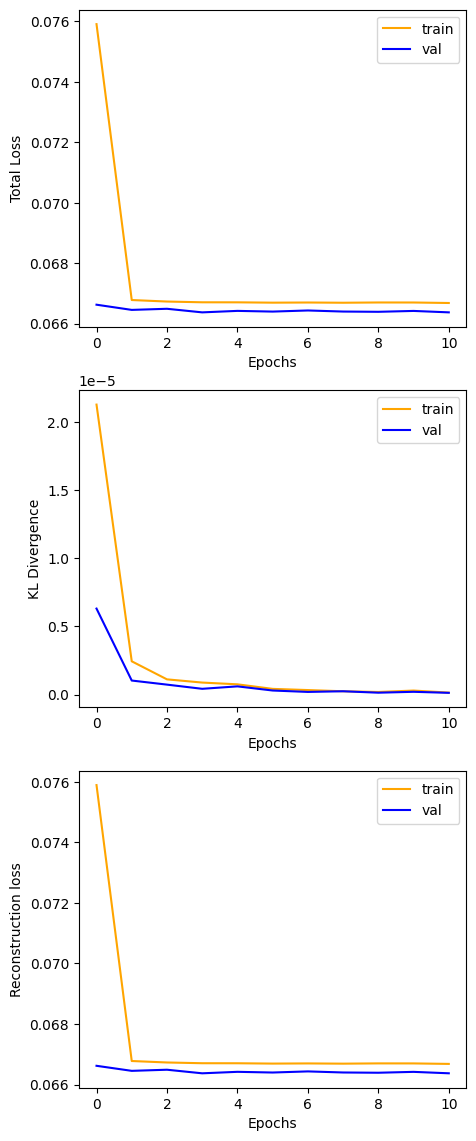

In [ ]:
visualize_results_vae(results)

In [ ]:
curr_time = get_current_time()
curr_time

'14_03_2024__13_59_52'

In [ ]:
PATH = os.getcwd() / Path(curr_time)
PATH.mkdir(parents=True, exist_ok=True)
model_name = "VAE2_1.pt"
optimizer_name = "Adam_1.pt"
# scheduler_name = "ReduceLROnPlateau.pt"

save_model_info(PATH, DEVICE, vae2, model_name, optimizer, optimizer_name)


Model info saved!


In [ ]:
NEW_LEARNING_RATE = optimizer.param_groups[0]["lr"]

loaded_model1 = VAE2(Encoder2(), Decoder2()).to(DEVICE)
loaded_optimizer1 = optim.Adam(params=loaded_model1.parameters(), lr=NEW_LEARNING_RATE)
# loaded_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1,
#                                                         mode="max", verbose=True)

load_model_info(PATH, DEVICE, loaded_model1, model_name, loaded_optimizer1,
                optimizer_name)

Model info loaded!


In [51]:
# Load the pretrained models
PATH = "/content/"
model_name = "VAE2_1.pt"
optimizer_name = "Adam_1.pt"

loaded_model2 = VAE2(Encoder2(), Decoder2()).to(DEVICE)
loaded_optimizer2 = optim.Adam(params=loaded_models2.parameters(), lr=3e-4)

load_model_info("PATH", DEVICE, loaded_model2, model_name, loaded_optimizer2,
                optimizer_name)

NameError: name 'loaded_models2' is not defined